## [Luis Alejandro Rodríguez Arenas](https://luigitoby.github.io/)  
## Cod. 202321287 
## Parte de G4
## Laboratorio 1 - Pre-informe

## Importación de librerías necesarias

In [21]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sympy import symbols, Matrix, pi, cos, sin, simplify, eye, solve, acos, asin,  latex, atan2, pprint, init_printing, Derivative, sqrt
from sympy.physics.mechanics import ReferenceFrame, dynamicsymbols, init_vprinting, Point

# Formato mathjax, porque me gusta mejor estas derivadas
init_vprinting(use_latex='mathjax')

# 2D

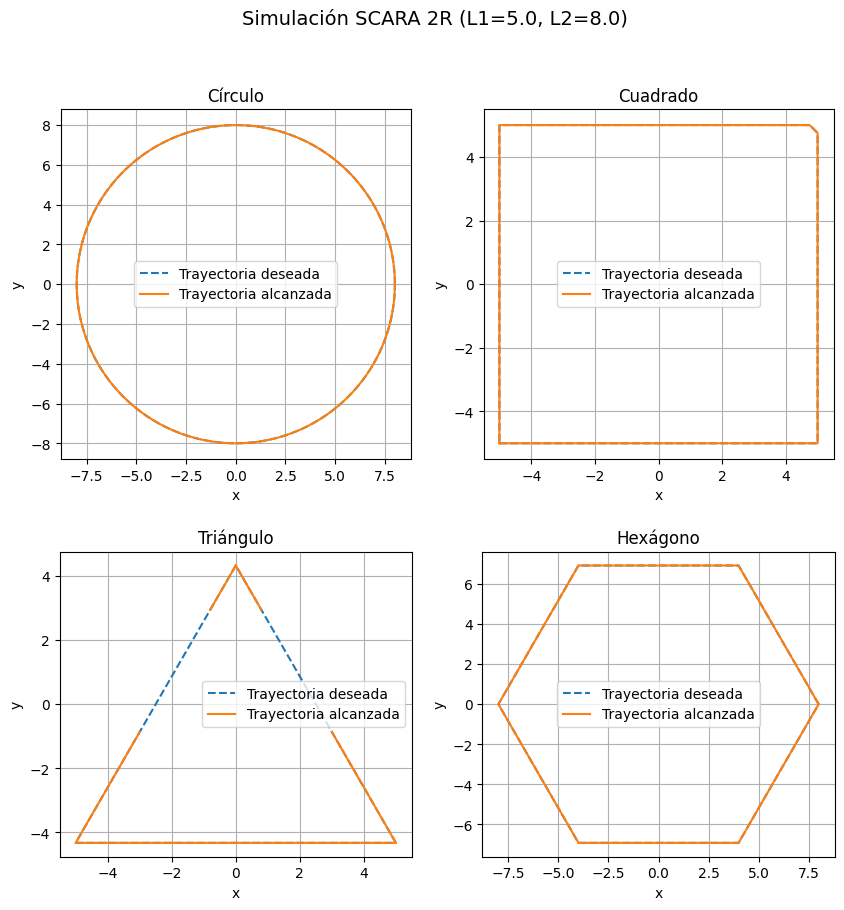

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Cinemática inversa (IK)
def cinematica_inversa(x, y, L1, L2, branch="down"):
    d2 = x*x + y*y
    if d2 > (L1 + L2)**2 or d2 < (L1 - L2)**2:
        return None
    c2 = (d2 - L1**2 - L2**2) / (2.0 * L1 * L2)
    c2 = np.clip(c2, -1.0, 1.0)
    theta2 = np.arccos(c2)
    if branch == "up":
        theta2 = -theta2
    k1 = L1 + L2 * np.cos(theta2)
    k2 = L2 * np.sin(theta2)
    theta1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    return np.degrees(theta1), np.degrees(theta2)

# Cinemática directa (FK)
def cinematica_directa(theta1_deg, theta2_deg, L1, L2):
    t1 = np.radians(theta1_deg)
    t2 = np.radians(theta2_deg)
    x = L1*np.cos(t1) + L2*np.cos(t1 + t2)
    y = L1*np.sin(t1) + L2*np.sin(t1 + t2)
    return x, y

# Trayectorias
def trayectoria_circulo(radio=8.0, n_puntos=200):
    t = np.linspace(0, 2*np.pi, n_puntos, endpoint=True)
    return [(radio*np.cos(tt), radio*np.sin(tt)) for tt in t]

def trayectoria_cuadrado(lado=10.0, n_puntos=160):
    pts = []
    seg = n_puntos//4
    xs = np.linspace(-lado/2,  lado/2, seg, endpoint=False)
    ys = np.linspace(-lado/2,  lado/2, seg, endpoint=False)
    pts += [(x, -lado/2) for x in xs]
    pts += [( lado/2, y) for y in ys]
    pts += [(x,  lado/2) for x in xs[::-1]]
    pts += [(-lado/2, y) for y in ys[::-1]]
    pts.append(pts[0])
    return pts

def trayectoria_triangulo(lado=10.0, n_puntos=150):
    h = np.sqrt(3)/2 * lado
    V = [(0, h/2), (-lado/2, -h/2), (lado/2, -h/2), (0, h/2)]
    seg = n_puntos//3
    pts = []
    for i in range(3):
        x1, y1 = V[i]
        x2, y2 = V[i+1]
        xs = np.linspace(x1, x2, seg, endpoint=False)
        ys = np.linspace(y1, y2, seg, endpoint=False)
        pts += list(zip(xs, ys))
    pts.append(V[0])
    return pts

def trayectoria_hexagono(radio=8.0, n_puntos=180):
    V = [(radio*np.cos(i*np.pi/3), radio*np.sin(i*np.pi/3)) for i in range(6)]
    V.append(V[0])
    seg = n_puntos//6
    pts = []
    for i in range(6):
        x1, y1 = V[i]
        x2, y2 = V[i+1]
        xs = np.linspace(x1, x2, seg, endpoint=False)
        ys = np.linspace(y1, y2, seg, endpoint=False)
        pts += list(zip(xs, ys))
    pts.append(V[0])
    return pts

# Simulación SCARA
def simular_robot_SCARA(L1, L2, T, branch="down"):
    angulos, tray_real = [], []
    for (x, y) in T:
        th = cinematica_inversa(x, y, L1, L2, branch=branch)
        if th is None:
            angulos.append(None)
            tray_real.append(None)
        else:
            x_r, y_r = cinematica_directa(th[0], th[1], L1, L2)
            angulos.append(th)
            tray_real.append((x_r, y_r))
    return angulos, tray_real

# Parámetros del robot
L1, L2 = 5.0, 8.0

# Diccionario de trayectorias
trayectorias = {
    "Círculo": trayectoria_circulo(radio=8.0),
    "Cuadrado": trayectoria_cuadrado(lado=10.0),
    "Triángulo": trayectoria_triangulo(lado=10.0),
    "Hexágono": trayectoria_hexagono(radio=8.0)
}

# Gráficas
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()

for i, (nombre, tray) in enumerate(trayectorias.items()):
    ang, tray_real = simular_robot_SCARA(L1, L2, tray, branch="down")
    xd, yd = zip(*tray)
    xr, yr = zip(*[(p if p is not None else (np.nan, np.nan)) for p in tray_real])
    axs[i].plot(xd, yd, '--', label='Trayectoria deseada')
    axs[i].plot(xr, yr, '-', label='Trayectoria alcanzada')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].set_title(nombre)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].grid(True)
    axs[i].legend()

plt.suptitle(f"Simulación SCARA 2R (L1={L1}, L2={L2})", fontsize=14)
plt.show()


# 3D

In [23]:
import numpy as np
import open3d as o3d

# Cinemática inversa y directa (las mismas de antes)
def cinematica_inversa(x, y, L1, L2, branch="down"):
    d2 = x*x + y*y
    if d2 > (L1 + L2)**2 or d2 < (L1 - L2)**2:
        return None
    c2 = (d2 - L1**2 - L2**2) / (2.0 * L1 * L2)
    c2 = np.clip(c2, -1.0, 1.0)
    theta2 = np.arccos(c2)
    if branch == "up":
        theta2 = -theta2
    k1 = L1 + L2 * np.cos(theta2)
    k2 = L2 * np.sin(theta2)
    theta1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    return np.degrees(theta1), np.degrees(theta2)

def cinematica_directa(theta1_deg, theta2_deg, L1, L2):
    t1 = np.radians(theta1_deg)
    t2 = np.radians(theta2_deg)
    x1, y1 = L1*np.cos(t1), L1*np.sin(t1)
    x2, y2 = x1 + L2*np.cos(t1 + t2), y1 + L2*np.sin(t1 + t2)
    return (x1, y1, 0), (x2, y2, 0)

# Trayectoria (círculo de prueba)
def trayectoria_circulo(radio=8.0, n_puntos=200):
    t = np.linspace(0, 2*np.pi, n_puntos, endpoint=True)
    return [(radio*np.cos(tt), radio*np.sin(tt)) for tt in t]

# Función para crear un cilindro entre dos puntos
def crear_cilindro(p1, p2, radio=0.2, color=[0, 0, 1]):
    p1, p2 = np.array(p1), np.array(p2)
    vec = p2 - p1
    length = np.linalg.norm(vec)
    if length < 1e-6:
        return None
    mesh = o3d.geometry.TriangleMesh.create_cylinder(radius=radio, height=length)
    mesh.paint_uniform_color(color)
    mesh.compute_vertex_normals()

    # Rotar cilindro (por defecto está alineado con z)
    z_axis = np.array([0,0,1])
    vec_norm = vec / length
    axis = np.cross(z_axis, vec_norm)
    if np.linalg.norm(axis) > 1e-6:
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.dot(z_axis, vec_norm))
        R = mesh.get_rotation_matrix_from_axis_angle(axis * angle)
        mesh.rotate(R, center=(0,0,0))
    mesh.translate(p1)
    return mesh

# Visualización SCARA
def visualizar_SCARA(L1, L2, trayectoria):
    geometries = []

    # Dibujar trayectoria deseada (línea amarilla)
    pts = [(x, y, 0) for x, y in trayectoria]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(pts),
        lines=o3d.utility.Vector2iVector([[i, i+1] for i in range(len(pts)-1)])
    )
    line_set.paint_uniform_color([1,1,0])
    geometries.append(line_set)

    # Dibujar configuración final del robot (último punto alcanzado)
    th = cinematica_inversa(trayectoria[-1][0], trayectoria[-1][1], L1, L2, branch="down")
    if th is not None:
        p1, p2 = cinematica_directa(th[0], th[1], L1, L2)

        esfera_o = o3d.geometry.TriangleMesh.create_sphere(radius=0.3)
        esfera_o.paint_uniform_color([0,0,0])

        esfera_p1 = o3d.geometry.TriangleMesh.create_sphere(radius=0.3)
        esfera_p1.translate(p1)
        esfera_p1.paint_uniform_color([1,0,0])

        esfera_p2 = o3d.geometry.TriangleMesh.create_sphere(radius=0.3)
        esfera_p2.translate(p2)
        esfera_p2.paint_uniform_color([0,1,0])

        link1 = crear_cilindro((0,0,0), p1, color=[0,0,1])
        link2 = crear_cilindro(p1, p2, color=[0,1,1])

        geometries += [esfera_o, esfera_p1, esfera_p2, link1, link2]

    # Mostrar escena
    o3d.visualization.draw_geometries(geometries)

# ------------------------
# Ejemplo
# ------------------------
L1, L2 = 5.0, 8.0
tray = trayectoria_circulo(radio=8.0)
visualizar_SCARA(L1, L2, tray)


ModuleNotFoundError: No module named 'open3d'

## Procesamiento datos tracker

       t      x      y
0  0.000 -8.637  16.14
1  0.064 -8.620  16.15
2  0.112 -8.635  16.14
3  0.176 -8.259  16.15
4  0.239 -7.927  16.21
       t      x      y
0  0.000  23.78 -5.175
1  0.127  23.78 -5.173
2  0.255  23.78 -5.174
3  0.496  23.86 -4.887
4  0.624  23.85 -4.916


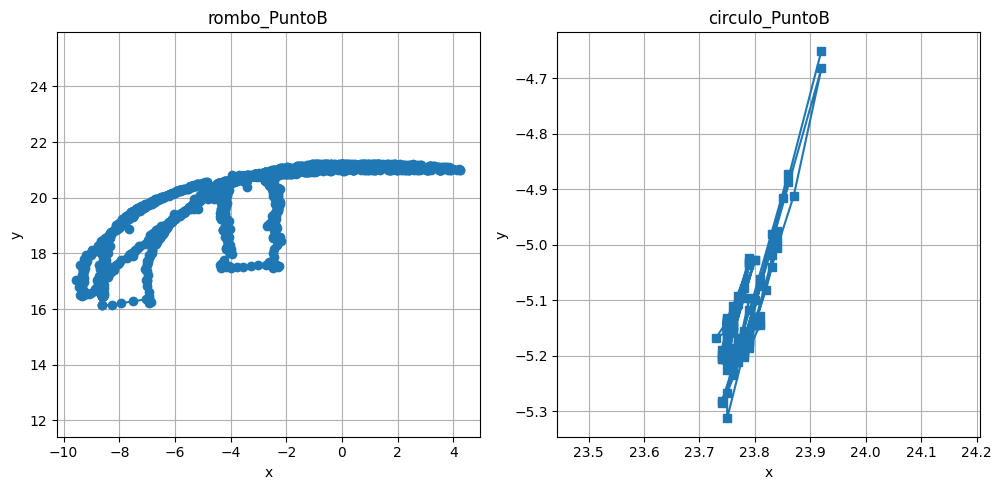

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta relativa del archivo
file_path = "datos_tracker.xlsx"

# Cargar hojas
rombo_df = pd.read_excel(file_path, sheet_name="rombo_PuntoB")
circulo_df = pd.read_excel(file_path, sheet_name="circulo_PuntoB")

print(rombo_df.head())
print(circulo_df.head())

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Gráfica rombo
axes[0].plot(rombo_df["x"], rombo_df["y"], marker="o", linestyle="-")
axes[0].set_title("rombo_PuntoB")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].axis("equal")
axes[0].grid(True)

# Gráfica círculo
axes[1].plot(circulo_df["x"], circulo_df["y"], marker="s", linestyle="-")
axes[1].set_title("circulo_PuntoB")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].axis("equal")
axes[1].grid(True)

plt.tight_layout()
plt.show()


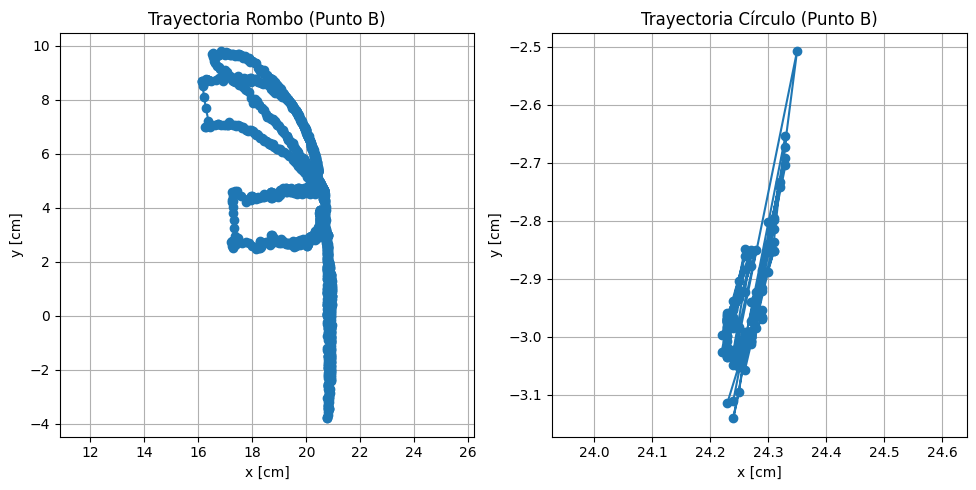

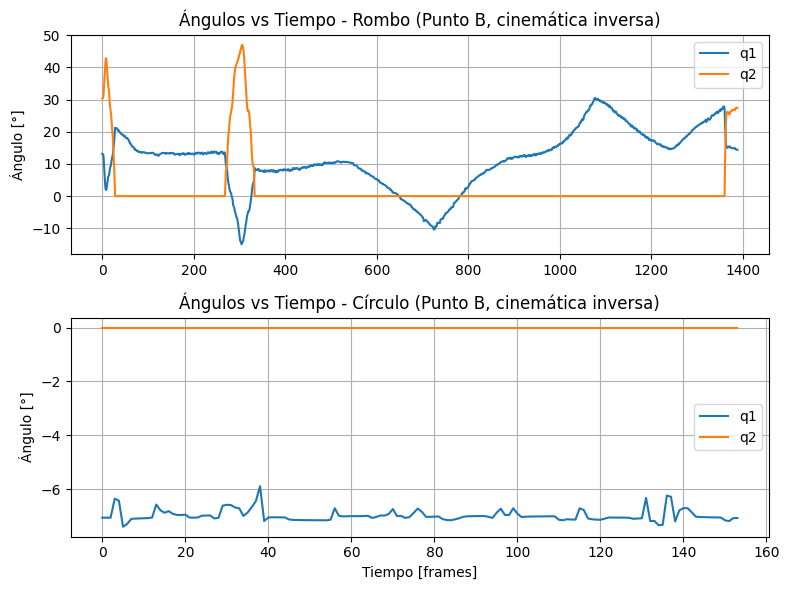

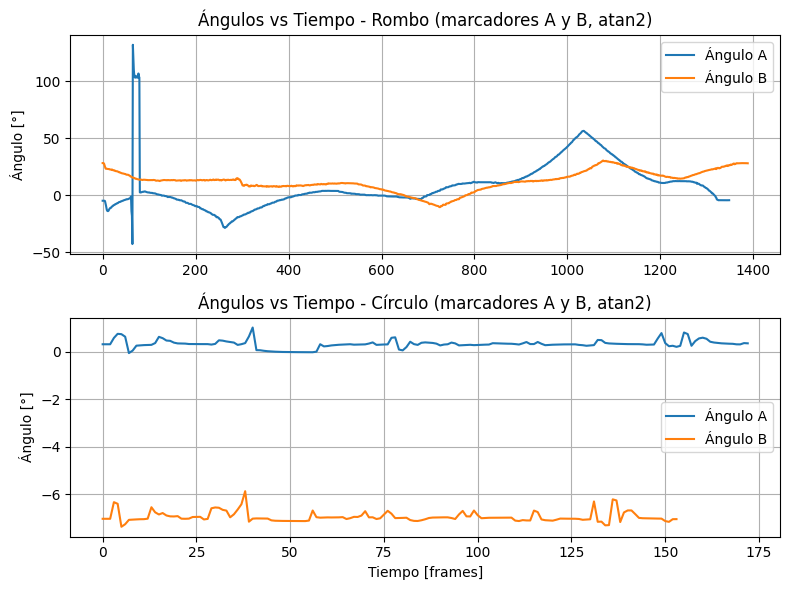

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta relativa del archivo
file_path = "datos_tracker.xlsx"

# Cargar hojas (puntos A y B de rombo y círculo)
rombo_b = pd.read_excel(file_path, sheet_name="rombo_b")
circulo_b = pd.read_excel(file_path, sheet_name="circulo_b")
rombo_a = pd.read_excel(file_path, sheet_name="rombo_a")
circulo_a = pd.read_excel(file_path, sheet_name="circulo_a")

# Parámetros del SCARA
l = 9.5  # longitud de cada eslabón en cm

# Cinemática inversa (para punto B)
def ik_scara(x, y, l):
    d = (x**2 + y**2 - 2*l**2) / (2*l**2)
    d = np.clip(d, -1.0, 1.0)  # asegurar dominio válido
    q2 = np.arccos(d)
    q1 = np.arctan2(y, x) - np.arctan2(l*np.sin(q2), l + l*np.cos(q2))
    return np.degrees(q1), np.degrees(q2)

# Calcular ángulos (cinemática inversa)
def compute_angles(df, l):
    q1_list, q2_list = [], []
    for xi, yi in zip(df["x"], df["y"]):
        q1, q2 = ik_scara(xi, yi, l)
        q1_list.append(q1)
        q2_list.append(q2)
    return np.array(q1_list), np.array(q2_list)

# Calcular ángulo directo de un marcador (simple atan2)
def marker_angle(df):
    return np.degrees(np.arctan2(df["y"], df["x"]))

# Ángulos inversa (para B)
q1_rombo, q2_rombo = compute_angles(rombo_b, l)
q1_circulo, q2_circulo = compute_angles(circulo_b, l)

# Ángulos directos (para A y B)
angulo_rombo_a = marker_angle(rombo_a)
angulo_rombo_b = marker_angle(rombo_b)
angulo_circulo_a = marker_angle(circulo_a)
angulo_circulo_b = marker_angle(circulo_b)

# --- Graficar ---

# 1. Trayectorias XY (rombo y círculo, solo B)
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(rombo_b["x"], rombo_b["y"], marker="o", linestyle="-", label="Punto B")
axes[0].set_title("Trayectoria Rombo (Punto B)")
axes[0].set_xlabel("x [cm]")
axes[0].set_ylabel("y [cm]")
axes[0].axis("equal")
axes[0].grid(True)

axes[1].plot(circulo_b["x"], circulo_b["y"], marker="o", linestyle="-", label="Punto B")
axes[1].set_title("Trayectoria Círculo (Punto B)")
axes[1].set_xlabel("x [cm]")
axes[1].set_ylabel("y [cm]")
axes[1].axis("equal")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 2. Ángulos q1 y q2 por cinemática inversa
fig, axes = plt.subplots(2, 1, figsize=(8,6))

t_rombo = np.arange(len(rombo_b))
t_circulo = np.arange(len(circulo_b))

axes[0].plot(t_rombo, q1_rombo, label="q1")
axes[0].plot(t_rombo, q2_rombo, label="q2")
axes[0].set_ylabel("Ángulo [°]")
axes[0].set_title("Ángulos vs Tiempo - Rombo (Punto B, cinemática inversa)")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t_circulo, q1_circulo, label="q1")
axes[1].plot(t_circulo, q2_circulo, label="q2")
axes[1].set_xlabel("Tiempo [frames]")
axes[1].set_ylabel("Ángulo [°]")
axes[1].set_title("Ángulos vs Tiempo - Círculo (Punto B, cinemática inversa)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# --- Ángulos directos de los marcadores A y B ---
fig, axes = plt.subplots(2, 1, figsize=(8,6))

# Rombo
t_rombo_a = np.arange(len(rombo_a))
t_rombo_b = np.arange(len(rombo_b))
axes[0].plot(t_rombo_a, angulo_rombo_a, label="Ángulo A")
axes[0].plot(t_rombo_b, angulo_rombo_b, label="Ángulo B")
axes[0].set_ylabel("Ángulo [°]")
axes[0].set_title("Ángulos vs Tiempo - Rombo (marcadores A y B, atan2)")
axes[0].legend()
axes[0].grid(True)

# Círculo
t_circulo_a = np.arange(len(circulo_a))
t_circulo_b = np.arange(len(circulo_b))
axes[1].plot(t_circulo_a, angulo_circulo_a, label="Ángulo A")
axes[1].plot(t_circulo_b, angulo_circulo_b, label="Ángulo B")
axes[1].set_xlabel("Tiempo [frames]")
axes[1].set_ylabel("Ángulo [°]")
axes[1].set_title("Ángulos vs Tiempo - Círculo (marcadores A y B, atan2)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

